## Image Classification, Resnet from scratch with CIFAR 10

CIFAR10 is a well known dataset in academia. Well before imagenet. In many ways, small datasets are much more interesting than imagenet. Most of the time you are working with a small number of images so learning these data sets are most interesting. For example, images where cancer nodule exists is like 32 x 32, small, like CIFAR. Imagenet is very expensive, and in many cases you should do it first on CIFAR. 

People aren't doing carefully tuned experiments, just throughing lots of GPUs and large imagenet type datasets. People also complain about MNIST. If you are trying to understand rich parts of your algorithm then using MNIST is a good idea (not too big). 

Download CIFAR from location from address below. If you Google for it, you will find some less convenient forms. 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz    
**Important:** Before proceeding, the student must reorganize the downloaded dataset files to match the expected directory structure, so that there is a dedicated folder for each class under 'test' and 'train', e.g.:

```
* test/airplane/airplane-1001.png
* test/bird/bird-1043.png

* train/bird/bird-10018.png
* train/automobile/automobile-10000.png
```

The filename of the image doesn't have to include its class.

In [2]:
from fastai.conv_learner import *
PATH = "data/cifar10/"
os.makedirs(PATH,exist_ok=True)

!ls {PATH}

if not os.path.exists(f"{PATH}/train/bird"):
   raise Exception("expecting class subdirs under 'train/' and 'test/'")
!ls {PATH}/train

test  train
airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


In [3]:
# list of classes
#  tuple = ("","",..) ...  Python immutable list
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# normally when useing pre-trained models ... the data is transformed by the model data transform  from model
#   creates normalised data set
# this time we are creating this from scratch, we need to normalize by std_dev and shift by mean
# mean and standard deviation per channel ... did not show the code you should be able to do this
#  first array is mean per channel  ... second array are std_dev per channel
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [4]:
# We are creating model from scratch so we will need transformation for augmentations 
# For Cifar10, people usually augment by flipping randomly, horizontally
#  below create specific list of augmentations
#  add black padding around the edge (pad = sz//8), randomly pick 32 x 32 image within
#    if you add pad parameter to any of the fastai transform parameters it will do that
#    for you
#    add 4 pixes around each side
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
# these are small so use batch size of 256
bs=256

### Look at data

In [6]:
data = get_data(32,4)

In [7]:
x,y=next(iter(data.trn_dl))

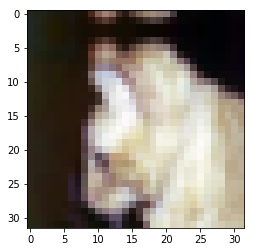

In [8]:
# sail boat
plt.imshow(data.trn_ds.denorm(x)[0]);

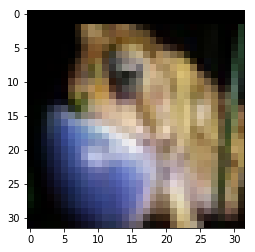

In [ ]:
# this is a frog
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully connected model

In [10]:
data = get_data(32,bs)

In [11]:
lr=1e-2

## Fully Connected Arhictecture (1 Hidden Layer)

Begin with a fully connected network, with input layer, 1 hidden layer, and output layer.

Start from rom [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

The Blog, shows how to create optimizers from scratch with momentum and Adam optimization.
It also contains a fully connected network generator, SimpleNet. Like the excel, class example, but used Python. We use his SimpleNet fully connected network  generatork.


In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        # class with list of fully connected layers
        # in PyTorch wrap it in nn.ModuleList to register as attributes
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        # flatten the data that comes in because fully connected
        x = x.view(x.size(0), -1)
        # go through each layer and call the linear layer, then RELU, 
        #   then finally softmax at the end 
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [ ]:
# now move higher abstraction in the API, above fit and create learn object
# rather than the fit model, create learn object from a custom model
# want convolutional learner, 
# from model
# from data using the SimpleNet model, and model data object
# simpler than RNN ... no callbacks or cosine anealing

learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

In [ ]:
# 1 hidden layer
# type learn to print it out 
# 3072 features coming in 32 x 32 x 3 ... 40 feature sout of first layer
# 10 CIFAR classes/categories out
# 122880 paramters
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40)
     (1): Linear(in_features=40, out_features=10)
   )
 ), [122880, 40, 400, 10])

In [ ]:
# .summary to show a bit more detail
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [ ]:
learn.lr_find()

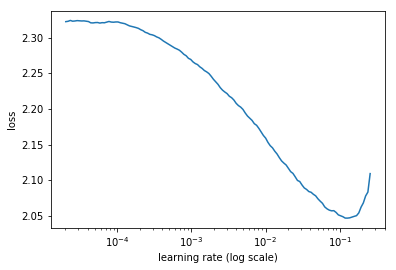

In [ ]:
learn.sched.plot()

In [ ]:
%time learn.fit(lr, 2)

A Jupyter Widget

[ 0.       1.7658   1.64148  0.42129]                       
[ 1.       1.68074  1.57897  0.44131]                       

CPU times: user 1min 11s, sys: 32.3 s, total: 1min 44s
Wall time: 55.1 s


In [ ]:
# 
# 1 hidden layer model
# 122880 parameters
# 47% accuracy ... not great. Lets try and improve it
# 
%time learn.fit(lr, 2, cycle_len=1)

A Jupyter Widget

[ 0.       1.60857  1.51711  0.46631]                       
[ 1.       1.59361  1.50341  0.46924]                       

CPU times: user 1min 12s, sys: 31.8 s, total: 1min 44s
Wall time: 55.3 s


## CNN

The goal will be to improve and build up to the basic architecture of a RESNET. Let's now adapt from the SimpleNet, fully connected architecture. Recall, that a fully connected layer is doing a dot product, matrix multiply. 

**Fully connected weight matrix**  
- every element of the input x every element of the output
- 3072 coming in 40 coming out 3072 x 40 parameters = 122,880 parameters.

Even for our crappy accuracy (~46%) ... lots of parameters, 3072 coming in 40 coming out 3072 x 40 parameters  = 122,880 parameters. Rather than fully connected layer, we really prefer to look for patterns with a convolution, a kernal, Tensor, with multiple filters (dimensions)  
We will replace nn.linear with nn.2d   

**Stride**    
Typically today do Stride 2 convolution 
 - instead of moving 1 to the right, move two to the right 
 - similar down two columns

**Adaptive max pooling** ... standard in image classification  
- not going to tell you how big an area to pool
- going to tell you how big a resolution to create
- Suppose input is 28 x 28 and do 14 x 14 (output resolution) max pool
  - that is the same as 2 x 2 (filter size)
- Suppose input is 28 x 28 and do 2 x 2 (output resolution) max pool
  - that is the same as 14 x 14 (filter size) 
  
**Penultimate Layer Adaptive Maxpooling**  
- Modern CNN. 1 x 1 max pool. Find the single largest cell and use that as our new activation.
- We now have 1 x 1 by number of features tensor 
 

In [1]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([  # module list registers all layers and parameters with PyTorch
            # first two parameters are the same as nn.linear 
            #   number of features coming in and features coming out
            # each time have layer, want to make the next layer smaller
            # previously did max pooling, not typical today. Instead, usually use stride 2
            # stride 2 has the same effect as max pooling, halving the resolution 
            # 3 x 3 filter 
            # stride of 2 convolution ... every second 
            # kernal size = 3, meaning 3 x 3 
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        
        # adaptive max pooling ... standard in image classification
        #   not going to tell you how big an area to pool
        #   going to tell you how big a resolution to create
        #   Suppose input is 28 x 28 and do 14 x 14 (output resolution) max pool
        #    that is the same as 2 x 2 (filter size)
        #   Suppose input is 28 x 28 and do 2 x 2 (output resolution) max pool
        #    that is the same as 14 x 14 (filter size)        
        #
        #   Penultamate layer in modern CNN is 1x1 adaptive max pool
        #     1x1 adaptive max pool resolution ... 
        #     single largest cell use that as our new activation
        #     now have 1 x 1 tensor by number of features
        self.pool = nn.AdaptiveMaxPool2d(1)
        #  last thing passed in is how many classes "c" used for the last layer
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
           # go through every convolutional layer and do the convolution and relu
        for l in self.layers: x = F.relu(l(x))
          # Adaptive max pool
        x = self.pool(x)      
           # Next statement returns matrix of size bs x N_features 
           #  ... feeds into last layer ... self.out
           # gets rid of trailing 1 x 1 axis
        x = x.view(x.size(0), -1) 
               
        return F.log_softmax(self.out(x), dim=-1)

NameError: name 'nn' is not defined

In [ ]:

#  ConvNet
#   3 channles coming in 
#   first layer out 20, 40, then 80

learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

#### learn summary - see here how it works ... 

fully convolutional network - all layers convolutional but the last layer  
Note, the 3 x 3 kernals will expand the dimensions, but our specified   
dimentions of 20, 40, 80 will then be applied resulting the sizes below  
- Goes from 3 x 32 x 32 , to 20 x 15 x 15 , 40 x 7 x7 , 80 x 3 x3 ...
- **Padding**
  - notice that the output of this layer is 15 x 15 not 16 x 16. This is because the 3 x 3 kernal does not pick up the edge. There is no padding. If we were to zero pad by 1, then it would pick up the edge and the output would be 16 x 16
  - also, with padding next layer will be 8 x 8 instead of 7 x 7
  - Padding doesn't make too much difference at the 15 x 15 layer, however when we get down to small layers like 3 x 3 then having 4 x 4 rather than 3 x 3 will make a difference.
- adaptive max pool makes it 80 x 1 x 1 ... 
- view makes it min batch size by 80 -> bs x 80
- linear layer takes from 80 to 10 

```
learn.summary()
OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict([('input_shape', [-1, 80]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 810)]))])
```

In [5]:
# learn.summary - see here how it works ... 
#  fully convolutional network - all layers convolutional but the last layer
#  Note, the 3 x 3 kernals will expand the dimensions, but our specified 
#   dimentions of 20, 40, 80 will then be applied resulting the sizes below
#    goes from 3 x 32 x 32 , to 20 x 15 x 15 , 40 x 7 x7 , 80 x 3 x3 ...
#    adaptive max pool makes it 80 x 1 x 1 ... 
#   .view makes it min batch size by 80 -> bs x 80
#    linear layer takes from 80 to 10 
learn.summary()


NameError: name 'learn' is not defined

In [ ]:
# went through all data set and kept getting better, default final learning rate 10
# overide to try more things 100

learn.lr_find(end_lr=100)

A Jupyter Widget

 70%|███████   | 138/196 [00:16<00:09,  6.42it/s, loss=2.49]

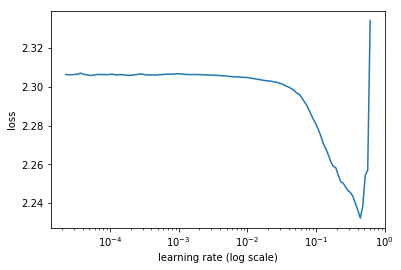

In [ ]:
learn.sched.plot()

In [ ]:
%time learn.fit(1e-1, 2)

A Jupyter Widget

[ 0.       1.72594  1.63399  0.41338]                       
[ 1.       1.51599  1.49687  0.45723]                       

CPU times: user 1min 14s, sys: 32.3 s, total: 1min 46s
Wall time: 56.5 s


In [ ]:
# accuracy improved from 46% to almost 60%
# network parameters around 30K, much smaller than before (128K) but have better accuracy
# time per epoch about 32s ... for small architectures time is due to memory transfers
%time learn.fit(1e-1, 4, cycle_len=1)

A Jupyter Widget

[ 0.       1.36734  1.28901  0.53418]                       
[ 1.       1.28854  1.21991  0.56143]                       
[ 2.       1.22854  1.15514  0.58398]                       
[ 3.       1.17904  1.12523  0.59922]                       

CPU times: user 2min 21s, sys: 1min 3s, total: 3min 24s
Wall time: 1min 46s


## Refactor CNN

- put less stuff in forward... calling relu every time not idea
- new class ConvLayer, convolution kernal 3, and also add padding

**More Layers**  add Batch Norm
- tried to add more layers but it was not "resilient"
   - smaller network not too accurate
   - larter network unstable
- try batch norm
- learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)
- back in the old days that was considered large network, but now considered quite simple

**Batch Normalization** (Batch Norm)  
- Batch norm a couple of years old, but key to keeping the network stable
- to use batch norm, just have to write nn.batchnorn, but we will write it from scratch
  

In [ ]:
# ConvLayer class keeps the ConvNet2 below simple and easier to maintain
#   easier to make sure it is correct
# Create NN layer
# Nice thing about PyTorch is 
#   Layer definition and NN definition identical
#     both have a Constructor and Layer
#   o Layer can be used as NN
#   o NN can be used as Layer

class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
          # sets the convolutional layer defaults, kernal, strid, padding ... 
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
          # forward contains RELU
    def forward(self, x): return F.relu(self.conv(x))

In [ ]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
                            # use ConvLayer
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
            # note here call adaptive max pool as a function
            # since it does not have any state don't need to do object (use class) as above
            #   no weights, not state, just call it as a function
            #   everything you can do as a class you can do as a function inside capital F
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [ ]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [ ]:
%time learn.fit(1e-1, 2)

A Jupyter Widget

[ 0.       1.70151  1.64982  0.3832 ]                       
[ 1.       1.50838  1.53231  0.44795]                       

CPU times: user 1min 6s, sys: 28.5 s, total: 1min 35s
Wall time: 48.8 s


In [ ]:
%time learn.fit(1e-1, 2, cycle_len=1)

A Jupyter Widget

[ 0.       1.51605  1.42927  0.4751 ]                       
[ 1.       1.40143  1.33511  0.51787]                       

CPU times: user 1min 6s, sys: 27.7 s, total: 1min 34s
Wall time: 48.7 s


## BatchNorm

**Basic idea**  
The basic idea of batch norm is we have some vector of activations (pretend mini-batch of 1). Coming into some layer, probably some convolutional matrix multiplication. Suppose its the identity matrix. Activations not getting bigger or smaller. Now imagine that it is 2 x Identity matrix, this would be expontinal growth. Gradients would explode exponentially. Challenge is that unlikely that weight matrices not going to cause activations to get smaller and smaller or bigger and bigger.  

Basic intuition is you normalize all the la  
Subtracting out means and normalizing then adding learned weights to do the same seems weired 
People dont know why exactly it works ... you are already normalizng   
Intuitively you are normalizing the data then you can shift and scale it using far fewer   paramters instad of shifting and scaling all convolutonal filters.  

**Normalize every layer**  
We start with zero mean std-dev of inputs. But, what we really want is to standardize every layer. 

**BN also regularizes**  
IT also regularizes ... you can reduce or decrease dropout

**Benefits of Batchnorm**  
- increase learning rates
- relisiliency of training
- add more layers 

**Batch Norm only during training**  
during validation you don't want to be changing the meaning of the model  
some layers are sensitive to the type of mode, for example, train or eval mode (test)  

**Pre Traiined Networks** 
If pre-trained network, should parameters not be changed if the layer is frozen. BN set freeze = True don't change the norms and variances. Sometimes for Pre-trained turn freeze on works better.

**Oblation study BN placement** 
try turning on and off different pieces of your network to see what is being excited. The paper puts BN after RELU though by obliation study there are better places. 


Dont see any reason not to use batch norm. May be a bii more challenging on RNN, but still possible. 

**Data Normalization**
Do it anyway, people using your data, will know how you normalize. Though, with batch norm, batch norm will normalize. Better to do your own initial normalization.

**RELU placement**  
The approach we use for RELU before the batchnorm. Resnet they are using Conv-RELU-BN-Conv-BN

In [ ]:
# BN Layer exactly like ConvLayer
# now don't have to standardize the input at all because it will do it automatically
# normailzing per channel at input, and later layers per filter
#  that is not enough, SGD "bloody minded"
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
           # like ConvLayer, has Conv2d, stride, kernal, padding ... 
           # by saying its an nn thats how we flag it to PyTorch to updated it through backprop
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
           # Conv and Relu
        x = F.relu(self.conv(x))
        
        # batch norm is after the RELU .. same place as in the paper 
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
           # true when applied to training set, not on validation set
           # during validation you don't want to be changing the meaning of the model
           #   some layers are sensitive to the type of mode, for example, train or eval (test)
        if self.training:
           # calculate means and std_dev of each channel
            # this also regularizes and also slighthly the meaning of the conv filters
            #   it has a regularizing effect can reduce or sometimes eliminate dropout
            #   when you add noise of any kind it regularizes
            # in real BN you use exponentially weighted average
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
            # subtract means and dev std_dev
            # the norm will not help, because SGD will try and undo it the next mini batch
            # so what we do we create a new multiplier for each channel and a new added value
            #   start them out as a addition bunch of zeros, and multipliers are 1's
            #   we potentially undo what we just did 
            #   these are done for each channel ... first layer 3 1's and 3 0's
            #  NN.parameter you are allowed to learn these as weights
            # Now, if wants to scale the layer up, can just scale this set trio of numbers
            #   not every parameter of the airport
            # Batch norm paper particularly interesting paper
            #   lots of people don't know quite how it works 
            #   intuitively, normalizing the data, and you can shift and scale
            #   using far few parameters than shifting and scaling all conv. filters
            # Essentially allows us to increase learning rates and allows us to add
            #   more layers
            # Note, in PyTorch version most likely add an Epsilon to the divide so do not divide by zero
        return (x-self.means) / self.stds *self.m + self.a

In [ ]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
            # also added a single convolutional layer at the start
            # To get closer to modern approaches
            # added a single convelutional layer at the start
            # with a bigger Kernal size and stride of 1
            #   want first layer to have a richer input
            #   used to have kernal of 3
            #   if start with input, convolution with bigger area
            #   allows to find bigger richer inputs with more features
            #   this case 5 x 5 
            #    spit out 10 5 x 5 filters 
            #   today 
            #   Today every state of the art DL Image processor starts out
            #   with a larger kernal e.g. 5x5, 7 x7 or even 11 x 11
            #   with quite a few filters, like 32 filters. 
            #   Because used stride of 1 and padding 
            #    (kernal size - 1)/ 2 = (5 - 1) 2 my output
            #    will be just as big as my input
            #   The difference is it will have more filters
            #   This is a good way of creating a richer starting point
            #   of sequence of convolutional layers
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
              # Change ConvLayer to BnLayer here 
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
# after adding the bn layer can now add more layers here
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [ ]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [ ]:
# after a couple of epochs up to 57%
%time learn.fit(3e-2, 2)

A Jupyter Widget

[ 0.       1.4966   1.39257  0.48965]                       
[ 1.       1.2975   1.20827  0.57148]                       

CPU times: user 1min 16s, sys: 32.5 s, total: 1min 49s
Wall time: 54.3 s


In [1]:
# After a few more up to 68%
%time learn.fit(1e-1, 4, cycle_len=1)

NameError: name 'learn' is not defined

```
[ 0.       1.20966  1.07735  0.61504]                       
[ 1.       1.0771   0.97338  0.65215]                       
[ 2.       1.00103  0.91281  0.67402]                       
[ 3.       0.93574  0.89293  0.68135]                        

CPU times: user 2min 34s, sys: 1min 4s, total: 3min 39s
Wall time: 1min 50s
```

## Deep BatchNorm

We see, from the previous training of the initial batchnorm model that the accuracy is continuting to increase. Looks encouraging. So, we will try some additional improvements. An obovious thing to try is increase depth of the model. 

We can't just add stride 2 layers because it keeps decreasing the stride and we are down to 2 x 2 at the end. 

Instead, for everyone stride 2 layer, create a stride 1 layer. Zip stride one and stride 2, so first do stride 2 then stride 1.



In [ ]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        
          # these are the original stride 2 layers
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
          # for every stride 2 layer also create a stride 1 layer
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
           # stitch the stride 1 and stride 2 layers together
           #  first do the stride 2, then the stride 1
           # now twice as deep
           # end with 2 x 2 that I had before
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
# depth is 5 x 2 + Conv input layer + output layer = 12
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [ ]:
# 2 epochs of training 
%time learn.fit(1e-2, 2)

A Jupyter Widget

[ 0.       1.53499  1.43782  0.47588]                       
[ 1.       1.28867  1.22616  0.55537]                       

CPU times: user 1min 22s, sys: 34.5 s, total: 1min 56s
Wall time: 58.2 s


In [ ]:
# after 2 more at 65% ... has not helped
%time learn.fit(1e-2, 2, cycle_len=1)

A Jupyter Widget

[ 0.       1.10933  1.06439  0.61582]                       
[ 1.       1.04663  0.98608  0.64609]                       

CPU times: user 1min 21s, sys: 32.9 s, total: 1min 54s
Wall time: 57.6 s


## Resnet

**Deep BatchNorm**
In the previous step (Deep Batch Norm), training a 12 layer network with batch norm did not help, though it converged. It's too deep even for batchnorm to handle it. Its possible to train 12 layer Conv net, but its difficult to do it properly, and its not really helping.

**Resnet**
Let's try replacing this with a Resnet. Create "ResnetLayer" class by inheriting from BnLayer and replacing forward with the following.
```
    def forward(self, x): return x + super().forward(x)
```
Everything else identical except, see below, addition of more layers layers, 3 times deeper (see __init__) and it will train beautfiully.

```
   y = x + f(x)  ,y = prediction from the previous layer
   where, f(x) a convolution (network)
   rearrange and get
   f(x) = y - x
```

**Residual**  
This new class is called a ResNet block. Predictions are my input plus a function of my input. Its trying to fit a function. Let's reorder the equation to the difference f(x) = y - x, the residual. What this is doing is trying to fit a fuction to the difference of target output and the input, this difference is the residual, the error. Try to find a set of convolutional weights that fills in the amount that I was off.

**Boosting**
```
  inputs               
   x_n -------------- + ----> x_n+1                    ----> ...  
        |             |           =  x+ f(x)                       next stage 
        |      --     |           f(x) at each layer               does the same
        |     |  |    |           tries to predict                 thing
         -->  |f | ---            and correct for residual
              |  |                error
               --       
               
               Each layer is zooming in, closer and closer to our answer
               each time get to a certain point, have a residual. At each
               layer we have a model, and at each layer we have a residual
               prediction of the error and correct. This is based on Boosting 
               theory              
```

Each layer is build a model, predict residual, make a correction then next layer build a model, predict the residual, make a correction, etc. 

A model based on predicting the residual error is based
Trick is that by specifying forward (y = x +(fx)) as the thing we are trying to calculate, then we get **boosting for free**, model based on the residual.

**Our New Resnet Model**  
We now have 3 layers  
- Standard batch norm layer ... reduce size by 2 (stride of 2)
- Resnet stride 1
- Another Resnet layer stride 1
Forward function has 
- zip the three layers
- conv at the start
- linear at the end

Fit keeps going up, fit it again and up  
- Resnet a very important development
- Allowed to create very deep networks
- The full resnet has two calculations







In [ ]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [ ]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:

learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [ ]:
wd=1e-5

In [ ]:
%time learn.fit(1e-2, 2, wds=wd)

A Jupyter Widget

[ 0.       1.58191  1.40258  0.49131]                       
[ 1.       1.33134  1.21739  0.55625]                       

CPU times: user 1min 27s, sys: 34.3 s, total: 2min 1s
Wall time: 1min 3s


In [ ]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

A Jupyter Widget

[ 0.       1.11534  1.05117  0.62549]                       
[ 1.       1.06272  0.97874  0.65185]                       
[ 2.       0.92913  0.90472  0.68154]                        
[ 3.       0.97932  0.94404  0.67227]                        
[ 4.       0.88057  0.84372  0.70654]                        
[ 5.       0.77817  0.77815  0.73018]                        
[ 6.       0.73235  0.76302  0.73633]                        

CPU times: user 5min 2s, sys: 1min 59s, total: 7min 1s
Wall time: 3min 39s


In [ ]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

A Jupyter Widget

[ 0.       0.8307   0.83635  0.7126 ]                        
[ 1.       0.74295  0.73682  0.74189]                        
[ 2.       0.66492  0.69554  0.75996]                        
[ 3.       0.62392  0.67166  0.7625 ]                        
[ 4.       0.73479  0.80425  0.72861]                        
[ 5.       0.65423  0.68876  0.76318]                        
[ 6.       0.58608  0.64105  0.77783]                        
[ 7.       0.55738  0.62641  0.78721]                        
[ 8.       0.66163  0.74154  0.7501 ]                        
[ 9.       0.59444  0.64253  0.78106]                        
[ 10.        0.53      0.61772   0.79385]                    
[ 11.        0.49747   0.65968   0.77832]                    
[ 12.        0.59463   0.67915   0.77422]                    
[ 13.        0.55023   0.65815   0.78106]                    
[ 14.        0.48959   0.59035   0.80273]                    
[ 15.        0.4459    0.61823   0.79336]                    
[ 16.   

## Resnet 2

**Normally draw with 2 convolutions**   

<img src="ResnetConcept.png" size="width:300px;height:300px;" >

```
 input -> 1st convolution -> 2nd convolutiohn -> then add back to the original 
```

Also, in every block, the first one not a resnet block, but a standard convolution with a stride of 2 (self.layers BnLayer kernal_xize=5 ...). This is not a resnet block, called a bottleneck layer. it is not a resnet block, stride 2

We will discuss Resnet architecture in part 2.

This is a resonable approximation for a modern architexture

**Increase size** 

```
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)
```

**Accuracy**  

85% ... pretty good 

Today most recent results are 97%, based on techniques like this

To get to state of the art results (discussed in 2nd part of the course). Data augmentation, regularization, tweeks on resnet. 

In [ ]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [ ]:
wd=1e-6

In [ ]:
%time learn.fit(1e-2, 2, wds=wd)

A Jupyter Widget

[ 0.       1.7051   1.53364  0.46885]                       
[ 1.       1.47858  1.34297  0.52734]                       

CPU times: user 1min 29s, sys: 35.4 s, total: 2min 4s
Wall time: 1min 6s


In [ ]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

A Jupyter Widget

[ 0.       1.29414  1.26694  0.57041]                       
[ 1.       1.21206  1.06634  0.62373]                       
[ 2.       1.05583  1.0129   0.64258]                       
[ 3.       1.09763  1.11568  0.61318]                       
[ 4.       0.97597  0.93726  0.67266]                        
[ 5.       0.86295  0.82655  0.71426]                        
[ 6.       0.827    0.8655   0.70244]                        

CPU times: user 5min 11s, sys: 1min 58s, total: 7min 9s
Wall time: 3min 48s


In [ ]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

A Jupyter Widget

[ 0.       0.92043  0.93876  0.67685]                        
[ 1.       0.8359   0.81156  0.72168]                        
[ 2.       0.73084  0.72091  0.74463]                        
[ 3.       0.68688  0.71326  0.74824]                        
[ 4.       0.81046  0.79485  0.72354]                        
[ 5.       0.72155  0.68833  0.76006]                        
[ 6.       0.63801  0.68419  0.76855]                        
[ 7.       0.59678  0.64972  0.77363]                        
[ 8.       0.71126  0.78098  0.73828]                        
[ 9.       0.63549  0.65685  0.7708 ]                        
[ 10.        0.56837   0.63656   0.78057]                    
[ 11.        0.52093   0.59159   0.79629]                    
[ 12.        0.66463   0.69927   0.76357]                    
[ 13.        0.58121   0.64529   0.77871]                    
[ 14.        0.52346   0.5751    0.80293]                    
[ 15.        0.47279   0.55094   0.80498]                    
[ 16.   

In [ ]:
learn.save('tmp3')

In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [ ]:
metrics.log_loss(y,preds), accuracy_np(preds,y)

(0.44507397166057938, 0.84909999999999997)

## Q and A

Can this Residual, ResNet, approach be aplied to other problems, not image problems?  
- great question, yes. So far, it's being ignored. 
- NLP transformer arcitecture, state of the art for translation, a simple ResNet structure. Skip connections, skiping over a layer, used.

### End